In [7]:
import os
import glob
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
from xml.etree import ElementTree as et

import torch
from torch.utils.data import Dataset,DataLoader,random_split
import torchvision
#from torchmetrics.detection import MeanAveragePrecision
#import cv2
import gc

classes = [_, 'tuta','oidium']  # classes: 0 index is reserved for background
NUM_CLASSES = 3

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms

In [ ]:
import subprocess
import torch

# Function to retrieve GPU info using subprocess
def get_gpu_info():
    try:
        # Run the nvidia-smi command
        gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
        return gpu_info.decode('utf-8')
    except subprocess.CalledProcessError as e:
        return f"Failed to get GPU info: {e.output.decode('utf-8')}"

# Check GPU availability and print the info
gpu_info = get_gpu_info()
if "failed" in gpu_info.lower():
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# Check if CUDA is available
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

# Memory info (in bytes)
total_memory, free_memory = torch.cuda.mem_get_info()

# Convert bytes to GB
total_memory_gb = total_memory / (1024**3)  # Convert to GB
free_memory_gb = free_memory / (1024**3)    # Convert to GB

# Print the memory in GB
print(f"Total memory: {total_memory_gb:.2f} GB")
print(f"Free memory: {free_memory_gb:.2f} GB")



Tue Sep  3 12:00:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti   WDDM  |   00000000:2D:00.0  On |                  Off |
|  0%   44C    P8             33W /  450W |    1575MiB /  24564MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
def non_max_suppression(bounding_boxes, confidence_score, threshold):
    """
    Non-max Suppression Algorithm

    @param list  Object candidate bounding boxes
    @param list  Confidence score of bounding boxes
    @param float IoU threshold

    @return Rest boxes after nms operation
    """
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        #picked_boxes.append(bounding_boxes[index])
        #picked_score.append(confidence_score[index])
        picked.append(index)

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked #picked_boxes, picked_score


# Splited in test and train 

In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mechanics/torchvision-transform-examples.ipynb
class GenData(Dataset):
    def __init__(self, files_dir, annotation_file, width, height, transformer):
        self.files_dir = files_dir
        self.annotation_file = annotation_file
        self.height = height
        self.width = width
        self.transformer = transformer
        self.imgs = []
        
        img_ann = []
        with open(self.annotation_file) as json_file: 
            data = json.load(json_file) 
            annotations = data["annotations"]
            for ann in annotations:
                img_ann.append(ann['_from_via']['filename'])
        img_name_ann = np.unique(img_ann)
        #print('Nr of img in annotation file: ', len(img_name_ann))
# TEST! RGB, 540 e 630
        spectral_img = [460, 540, 630, 850, 980 ] # 460, 540, 630, 850, 980 
        n,a = 0,0
        for image in sorted(list(set(os.listdir(self.files_dir)) - {'desktop.ini', 'whatever.ini'})):
            if image.split('@')[4]=='COLOR_Image.png':
                if image in img_name_ann:
                    self.imgs.append(image)
                    a += 1
                    for im in spectral_img:
                        spectral_img_name = image.replace(image.split('@')[4], 'Image_'+str(im)+'.png')
                        self.imgs.append(spectral_img_name)
                else:
                    n +=1
                    #print(str(n)+') Img without annotation: ', image)

        #print('Nr of img without annotation: ', n)
        #print('Nr of img with annotation: ', a)

    def __getitem__(self, item):
        img_name = self.imgs[item]
        wt, ht = 0,0
        newsize = (self.height, self.width)
        if img_name.split('@')[4] == 'COLOR_Image.png':
            rgb_img_path =  self.files_dir + img_name #'./EBCC/' + img_name
            rgb_img = Image.open(rgb_img_path)#.convert('RGB') L RGB
            wt, ht = rgb_img.size
            img = rgb_img.resize(newsize)
            img = transformer(img)
        else:
            spectral_img_path = self.files_dir + img_name #'./images/' + imgs_spectral_name
            spectral_img = Image.open(spectral_img_path)#.convert('L') L RGB
            wt, ht = spectral_img.size
            img = spectral_img.resize(newsize)
            img = transformer(img)
            print(img.size())
            img_name = img_name.replace(img_name.split('@')[4], 'COLOR_Image.png')
           
        boxes, labels = [], [] 
        with open(self.annotation_file) as json_file: 
            data = json.load(json_file) 
            annotations = data["annotations"]
            for ann in annotations:
                if img_name == ann['_from_via']['filename']:
                    classe = ann['_from_via']['region_attributes']['name']
                    labels.append(classes.index(classe))          
                    cx,cy,w,h =  ann['bbox']  # bounding box
                    cx = (cx/wt)*self.width
                    w = (w/wt)*self.width
                    cy = (cy/ht)*self.height
                    h = (h/ht)*self.height
                    #boxes.append([cx, cy, w, h])
                    xmin = cx 
                    ymin = cy
                    xmax = cx + w
                    ymax = cy + h
                    boxes.append([xmin, ymin, xmax, ymax])
            if len(boxes) == 0:
                print('Bounding boxes array is empty for img: ', img_name)
       
        bbox = torch.tensor(boxes,dtype=torch.float32)
        label = torch.as_tensor(labels, dtype=torch.int64).reshape(-1,)
        target = {}
        target['boxes'] = bbox
        target['labels'] = label
        #target['img_name'] = self.imgs[item] # torch.tensor([0, 460, 540, 630, 850, 980], dtype=torch.int64)
        return img, target # img, target
    def __len__(self):
        return len(self.imgs)

train_dir = './dataset/TRAIN/'
test_dir = './dataset/TEST/'
annotation_file = './dataset/soup-dataset_whole.json'

dataset_train = GenData(train_dir, annotation_file, 480, 480, transformer)
dataset_test = GenData(test_dir, annotation_file, 480, 480, transformer)


def detection_collate(x):
    return list(tuple(zip(*x)))
dl_train = DataLoader(dataset_train,1,shuffle=True,collate_fn=detection_collate)
dl_test = DataLoader(dataset_test,1,shuffle=False,collate_fn=detection_collate) # shuffle=True
print('LEN Dataset: ', len(dl_train)+len(dl_test), '-> Train: ', len(dl_train), ' - Test: ', len(dl_test), 'Test Samples: ',  len(dl_test)/6 )

all_dataset_test = DataLoader(dataset_test,1,shuffle=False,collate_fn=detection_collate) # shuffle=True
print(' Test len: ', len(all_dataset_test))


LEN Dataset:  1374 -> Train:  1164  - Test:  210 Test Samples:  35.0
 Test len:  210


## Load Models weights for each types of images



In [ ]:
# Select CPU | GPU use ('cuda' or 'cuda:0')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_rgb=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_rgb.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_RGBimgs_13_10_23.pt', map_location=device))  # Choose whatever GPU device number you want
model_rgb.to(device) # Make sure to call input = input.to(device) on any input tensors that you feed to the model
model_rgb.eval()

model_r460=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_r460.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_460nmImgs_16_10_23.pt', map_location=device))  # Choose whatever GPU device number you want
model_r460.to(device)
model_r460.eval()

model_r540=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_r540.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_540nmImgs_16_10_23.pt', map_location=device))  # Choose whatever GPU device number you want
model_r540.to(device)
model_r540.eval()

model_r630=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_r630.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_630nmImgs_16_10_23.pt', map_location=device))  # Choose whatever GPU device number you want
model_r630.to(device)
model_r630.eval()

model_r850=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_r850.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_850nmImgs_16_10_23.pt', map_location=device))  # Choose whatever GPU device number you want
model_r850.to(device)
model_r850.eval()

model_r980=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=len(classes)) #model = TheModelClass(*args, **kwargs)
model_r980.load_state_dict(torch.load('./weights/fasterrcnn_30epotch_forTest_980nmImgs_16_10_23.pt', map_location="cuda:0"))  # Choose whatever GPU device number you want
model_r980.to(device)
model_r980.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
l = ['RGB', 460, 540, 630, 850, 980]
rgb_data, r460_data, r540_data, r630_data, r850_data, r980_data = [], [], [], [], [], []
data_labels = []

data_lists = [rgb_data, r460_data, r540_data, r630_data, r850_data, r980_data]

for idx, (imgs, labels) in enumerate(tqdm(all_dataset_test)):
    img = np.transpose(np.array(imgs[0]), (1, 2, 0)) * 255
    img = img.astype(np.uint8)
    i = idx % 6
    data_lists[i].append(img)
    if i == 0:
        data_labels.append(labels)


  1%|▏         | 3/210 [00:00<00:17, 11.79it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


  2%|▏         | 5/210 [00:00<00:15, 13.07it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


  4%|▍         | 9/210 [00:00<00:16, 12.15it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


  5%|▌         | 11/210 [00:01<00:19, 10.02it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


  7%|▋         | 15/210 [00:01<00:17, 10.84it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


  9%|▉         | 19/210 [00:01<00:17, 10.82it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 11%|█         | 23/210 [00:02<00:15, 12.30it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 13%|█▎        | 27/210 [00:02<00:17, 10.71it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 14%|█▍        | 29/210 [00:02<00:15, 11.49it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 16%|█▌        | 33/210 [00:02<00:15, 11.47it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 17%|█▋        | 35/210 [00:03<00:15, 11.59it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 18%|█▊        | 37/210 [00:03<00:16, 10.60it/s]

torch.Size([1, 480, 480])


 20%|█▉        | 41/210 [00:03<00:16, 10.35it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 21%|██▏       | 45/210 [00:04<00:15, 10.82it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 22%|██▏       | 47/210 [00:04<00:14, 11.03it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 24%|██▍       | 51/210 [00:04<00:14, 11.17it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 25%|██▌       | 53/210 [00:04<00:15, 10.12it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 27%|██▋       | 57/210 [00:05<00:14, 10.65it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 28%|██▊       | 59/210 [00:05<00:12, 11.62it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 30%|███       | 63/210 [00:05<00:11, 12.51it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 31%|███       | 65/210 [00:05<00:11, 13.06it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 33%|███▎      | 69/210 [00:06<00:13, 10.50it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 34%|███▍      | 71/210 [00:06<00:12, 11.20it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 36%|███▌      | 75/210 [00:06<00:12, 11.21it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 37%|███▋      | 77/210 [00:07<00:11, 11.87it/s]

torch.Size([1, 480, 480])


 38%|███▊      | 79/210 [00:07<00:12, 10.51it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 40%|███▉      | 83/210 [00:07<00:12, 10.38it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 41%|████▏     | 87/210 [00:08<00:11, 10.58it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 42%|████▏     | 89/210 [00:08<00:10, 11.33it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 44%|████▍     | 93/210 [00:08<00:10, 11.18it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 45%|████▌     | 95/210 [00:08<00:11,  9.65it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 47%|████▋     | 99/210 [00:09<00:10, 11.00it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 48%|████▊     | 101/210 [00:09<00:09, 11.49it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 50%|█████     | 105/210 [00:09<00:08, 11.79it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 51%|█████     | 107/210 [00:09<00:08, 12.26it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 53%|█████▎    | 111/210 [00:10<00:09, 10.87it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 55%|█████▍    | 115/210 [00:10<00:08, 11.11it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 57%|█████▋    | 119/210 [00:10<00:07, 12.10it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 58%|█████▊    | 121/210 [00:11<00:08, 11.10it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 59%|█████▊    | 123/210 [00:11<00:09,  9.62it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 60%|██████    | 127/210 [00:11<00:07, 10.51it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 62%|██████▏   | 131/210 [00:12<00:06, 12.35it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 64%|██████▍   | 135/210 [00:12<00:06, 12.45it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 65%|██████▌   | 137/210 [00:12<00:06, 10.45it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 67%|██████▋   | 141/210 [00:13<00:06, 10.68it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 68%|██████▊   | 143/210 [00:13<00:05, 11.29it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 70%|███████   | 147/210 [00:13<00:05, 11.14it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 71%|███████   | 149/210 [00:13<00:05, 11.75it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 73%|███████▎  | 153/210 [00:14<00:05, 10.03it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 74%|███████▍  | 155/210 [00:14<00:05, 10.92it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 76%|███████▌  | 159/210 [00:14<00:04, 10.88it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 77%|███████▋  | 161/210 [00:14<00:04, 11.15it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 78%|███████▊  | 163/210 [00:15<00:04, 10.59it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 80%|███████▉  | 167/210 [00:15<00:04, 10.53it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 81%|████████▏ | 171/210 [00:15<00:03, 10.91it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 82%|████████▏ | 173/210 [00:16<00:03, 11.54it/s]

torch.Size([1, 480, 480])


 84%|████████▍ | 177/210 [00:16<00:02, 11.40it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 85%|████████▌ | 179/210 [00:16<00:03, 10.04it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 87%|████████▋ | 183/210 [00:16<00:02, 10.81it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 88%|████████▊ | 185/210 [00:17<00:02, 11.61it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 90%|█████████ | 189/210 [00:17<00:01, 11.42it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 91%|█████████ | 191/210 [00:17<00:01, 11.88it/s]

torch.Size([1, 480, 480])


 93%|█████████▎| 195/210 [00:18<00:01, 10.76it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 94%|█████████▍| 197/210 [00:18<00:01, 11.05it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 96%|█████████▌| 201/210 [00:18<00:00, 11.34it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 97%|█████████▋| 203/210 [00:18<00:00, 11.58it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


 98%|█████████▊| 205/210 [00:18<00:00, 10.76it/s]

torch.Size([1, 480, 480])


100%|█████████▉| 209/210 [00:19<00:00, 10.78it/s]

torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])
torch.Size([1, 480, 480])


100%|██████████| 210/210 [00:19<00:00, 10.79it/s]


Len_rgb:  35


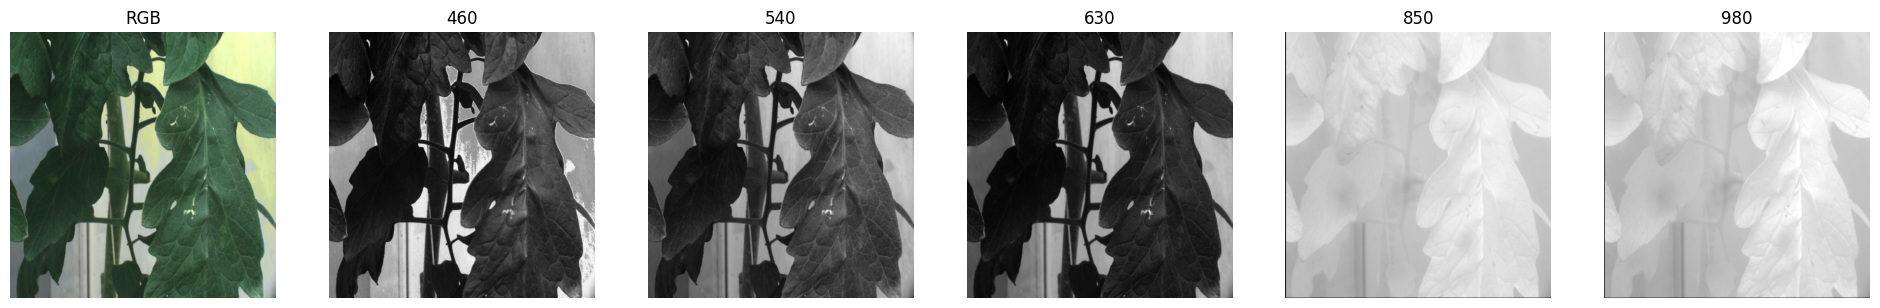

In [326]:
print('Len_rgb: ', len(rgb_data))
a = 14 # 7 8 9
fig, axes = plt.subplots(1, 6, figsize=(24, 14))
axes[0].imshow(rgb_data[a])
axes[1].imshow(r460_data[a], cmap='gray')
axes[2].imshow(r540_data[a], cmap='gray')
axes[3].imshow(r630_data[a], cmap='gray')
axes[4].imshow(r850_data[a], cmap='gray')
axes[5].imshow(r980_data[a], cmap='gray')
for i in range(len(l)):
    axes[i].set_title(l[i])
    axes[i].axis("off")
    

indexes:  [0, 1, 2] len:  3
indexes:  [0, 1, 2, 3, 5, 6, 7, 8, 12, 13] len:  10
indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 10] len:  9
indexes:  [0] len:  1
indexes:  [0] len:  1


(-0.5, 479.5, 479.5, -0.5)

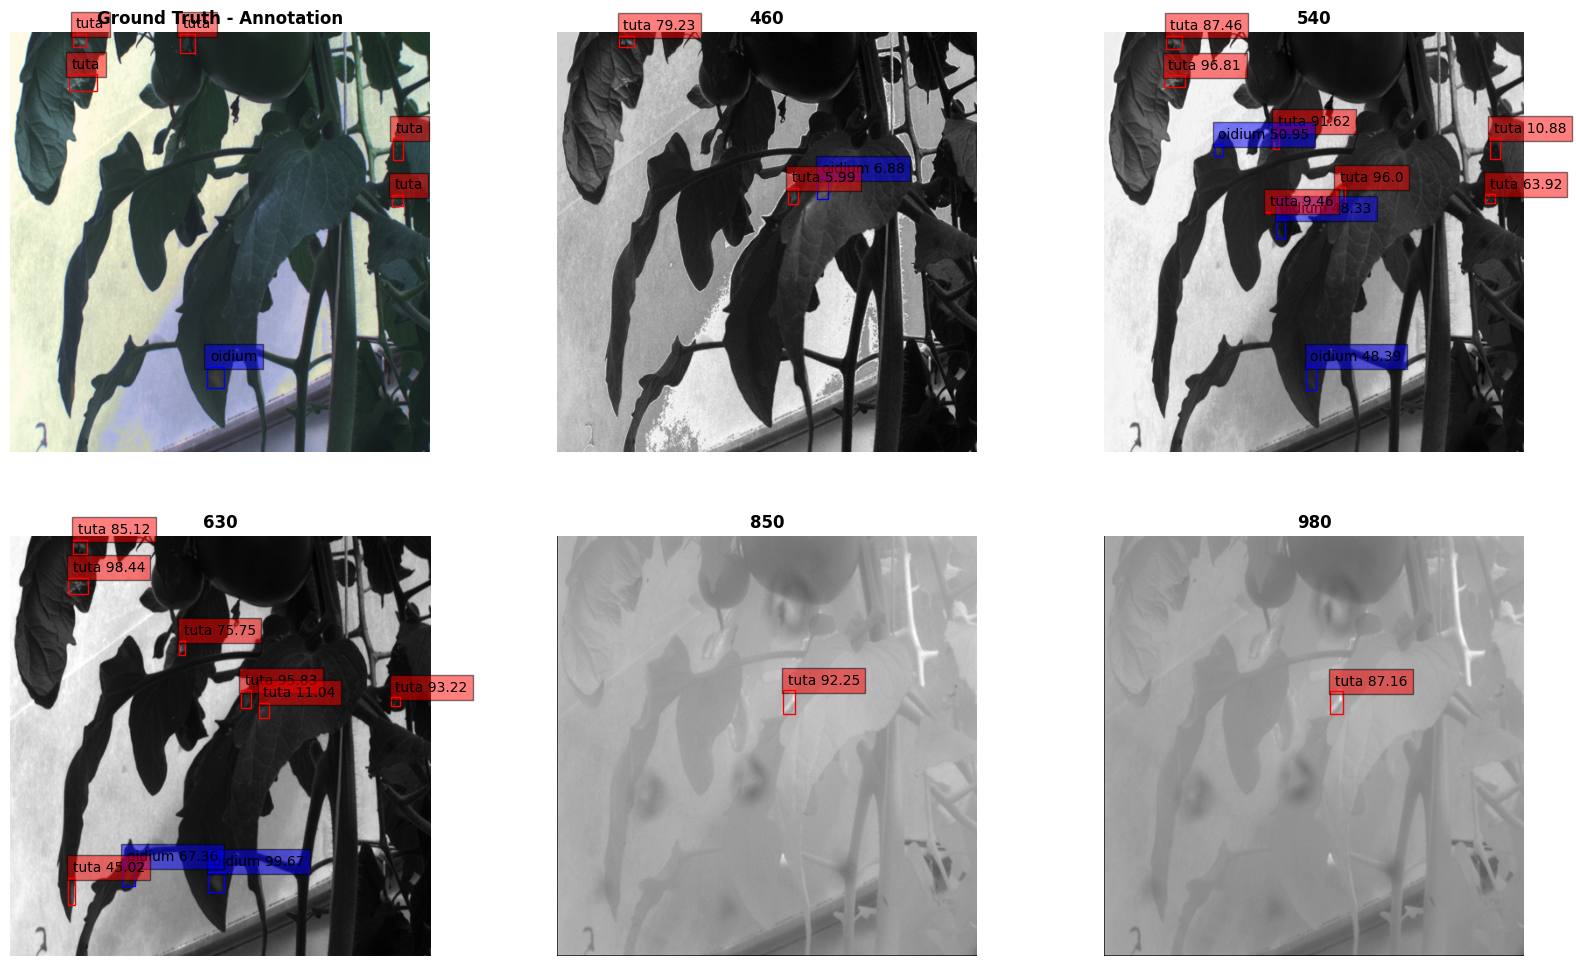

In [ ]:
a = 6 # 96 181 26 7
img = rgb_data[a]
labels = data_labels[a]
#img, label = next(iter(dl_test)) # img, target = dataset[30] 

box1 = labels[0]['boxes'].numpy()
label1 = labels[0]['labels'].numpy()
#print('Image name: ', label[0]['img_name'])

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(20, 12)) 
for i in range(len(label1)):
    x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
    label = str(classes[label1[i]])
    if label == 'tuta':
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
        axes[0,0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='red', alpha=0.5))
    else:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'blue', facecolor = 'none')
        axes[0,0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='blue', alpha=0.5))
    axes[0,0].add_patch(rect)
axes[0,0].imshow(img)
axes[0,0].set_title('Ground Truth - Annotation', fontweight ="bold")
axes[0,0].axis('off')


img_r460 = r460_data[a]
img_tensor = torch.from_numpy(img_r460/255.).permute(2,0,1).float().cuda()
out = model_r460(torch.unsqueeze(img_tensor,dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()

indexes = non_max_suppression(boxes, scores, 0.01)
#print(scores, labels, 'len: ', len(labels))
print('indexes: ', sorted(indexes), 'len: ', len(indexes))
for idx in indexes:     #range(boxes.shape[0]):
    if scores[idx] >= 0.05: 
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        #print('Labele', labels[idx].item(), 'Name: ', name, 'Score: ', score)
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[0,1].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[0,1].add_patch(rect)

axes[0,1].imshow(img_r460, cmap='gray')
axes[0,1].set_title('460', fontweight ="bold")
axes[0,1].axis('off')


img_r540 = r540_data[a]
img_tensor = torch.from_numpy(img_r540/255.).permute(2,0,1).float().cuda()
out = model_r540(torch.unsqueeze(img_tensor,dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()

indexes = non_max_suppression(boxes, scores, 0.01)
print('indexes: ', sorted(indexes), 'len: ', len(indexes))
for idx in indexes:
    if scores[idx] >= 0.05: 
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[0,2].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[0,2].add_patch(rect)

axes[0,2].imshow(img_r540, cmap='gray')
axes[0,2].set_title('540', fontweight ="bold")
axes[0,2].axis('off')


img_r630 = r630_data[a]
img_tensor = torch.from_numpy(img_r630/255.).permute(2,0,1).float().cuda()
out = model_r630(torch.unsqueeze(img_tensor, dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()

indexes = non_max_suppression(boxes, scores, 0.01)
print('indexes: ', sorted(indexes), 'len: ', len(indexes))
for idx in indexes:
    if scores[idx] >= 0.05: 
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[1,0].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[1,0].add_patch(rect)

axes[1,0].imshow(img_r630, cmap='gray')
axes[1,0].set_title('630', fontweight ="bold")
axes[1,0].axis('off')


img_r850 = r850_data[a]
img_tensor = torch.from_numpy(img_r850/255.).permute(2,0,1).float().cuda()
out = model_r850(torch.unsqueeze(img_tensor, dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()

indexes = non_max_suppression(boxes, scores, 0.01)
print('indexes: ', sorted(indexes), 'len: ', len(indexes))
for idx in indexes:
    if scores[idx] >= 0.05: 
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[1,1].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[1,1].add_patch(rect)

axes[1,1].imshow(img_r850, cmap='gray')
axes[1,1].set_title('850', fontweight ="bold")
axes[1,1].axis('off')


img_r980 = r980_data[a]
img_tensor = torch.from_numpy(img_r980/255.).permute(2,0,1).float().cuda()
out = model_r980(torch.unsqueeze(img_tensor, dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()

indexes = non_max_suppression(boxes, scores, 0.01)
print('indexes: ', sorted(indexes), 'len: ', len(indexes))
for idx in indexes:
    if scores[idx] >= 0.05: 
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        if name == 'tuta':
            color = 'red'
        else:
            color = 'blue'
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
        axes[1,2].text(x1+5, y1-7, name+' '+str(round(score*100,2)), bbox=dict(facecolor=color, alpha=0.5))
        axes[1,2].add_patch(rect)

axes[1,2].imshow(img_r980, cmap='gray')
axes[1,2].set_title('980', fontweight ="bold")
axes[1,2].axis('off')

(-0.5, 479.5, 479.5, -0.5)

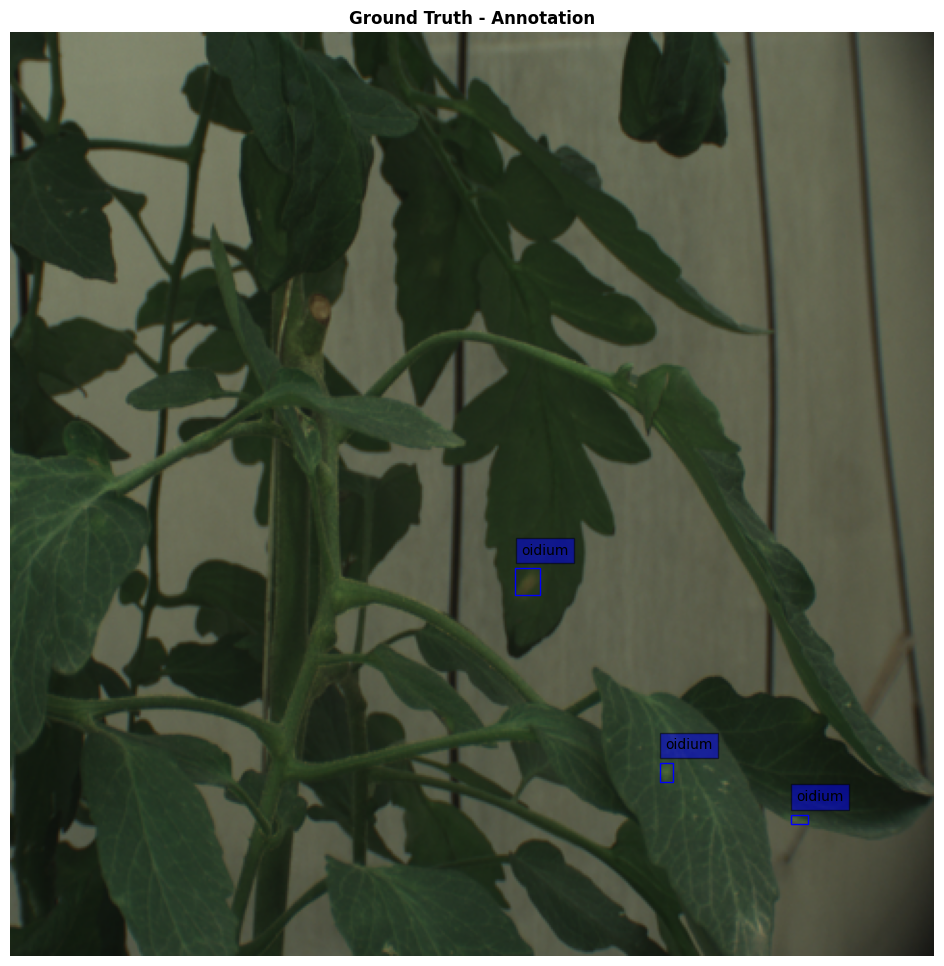

In [222]:
a = 9 #5 6 7 8 9 12 14 19 22 23 24 28
img = rgb_data[a] #r540_data[a]
w,h,chanels = img.shape
label = data_labels[a]
box1 = label[0]['boxes'].numpy()
label1 = label[0]['labels'].numpy()
#print('Image name: ', label[0]['img_name'])

fig, axes = plt.subplots(1, 1, figsize=(12, 12)) 
for i in range(len(label1)):
    x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
    label = str(classes[label1[i]])
    if label == 'tuta':
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
        axes.text(x1 + 3, y1 -7, label, bbox=dict(facecolor='red', alpha=0.5))
    else:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'blue', facecolor = 'none')
        axes.text(x1 + 3, y1 -7, label, bbox=dict(facecolor='blue', alpha=0.5))
    axes.add_patch(rect)
if chanels == 1:
    axes.imshow(img, cmap='gray')
else:   
    axes.imshow(img)
axes.set_title('Ground Truth - Annotation', fontweight ="bold")
axes.axis('off')

## Multi-images -> Multi-Models Ensamble -> Merge -> Prediction

In [ ]:
# MME architecture
#IMGs_RGB   ->  Model_RGB    -> bboxes lables scores ref_model -|
#IMGs_460nm ->  Model_R460nm -> bboxes lables scores ref_model -| -> Merge -> NonMaxSoppresion -> bboxes lables max-scores ref_models
# .....                                                        -|
#IMGs_980nm ->  Model_R980nm -> bboxes lables scores ref_model _|


def evaluate_multi_models(img_rgb, r460, r540, r630, r850, r980):
    boxes = []
    scores = []
    labels = [] 
    model_names = []
    img_rgb_tensor = torch.from_numpy(img_rgb/255.).permute(2,0,1).float().cuda()
    img_rgb_out = model_rgb(torch.unsqueeze(img_rgb_tensor, dim=0))
    boxes.append(img_rgb_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(img_rgb_out[0]['scores'].cpu().detach().numpy())
    labels.append(img_rgb_out[0]['labels'].cpu().detach().numpy())
    #model_names.append('M_RGB')
    model_names.append(['M_RGB' for i in range(len(img_rgb_out[0]['labels'].cpu().detach().numpy()))])
    #print(scores, labels, 'labels len: ', len(labels))

    img_r460_tensor = torch.from_numpy(r460/255.).permute(2,0,1).float().cuda()
    r460_out = model_r460(torch.unsqueeze(img_r460_tensor,dim=0))
    boxes.append(r460_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(r460_out[0]['scores'].cpu().detach().numpy())
    labels.append(r460_out[0]['labels'].cpu().detach().numpy())
    model_names.append(['M_R460' for i in range(len(r460_out[0]['labels'].cpu().detach().numpy()))])

    img_r540_tensor = torch.from_numpy(r540/255.).permute(2,0,1).float().cuda()
    r540_out = model_r540(torch.unsqueeze(img_r540_tensor,dim=0))
    boxes.append(r540_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(r540_out[0]['scores'].cpu().detach().numpy())
    labels.append(r540_out[0]['labels'].cpu().detach().numpy())
    model_names.append(['M_R540' for i in range(len(r540_out[0]['labels'].cpu().detach().numpy()))])

    img_r630_tensor = torch.from_numpy(r630/255.).permute(2,0,1).float().cuda()
    r630_out = model_r630(torch.unsqueeze(img_r630_tensor,dim=0))
    boxes.append(r630_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(r630_out[0]['scores'].cpu().detach().numpy())
    labels.append(r630_out[0]['labels'].cpu().detach().numpy())
    model_names.append(['M_R630' for i in range(len(r630_out[0]['labels'].cpu().detach().numpy()))])

    img_r850_tensor = torch.from_numpy(r850/255.).permute(2,0,1).float().cuda()
    r850_out = model_r850(torch.unsqueeze(img_r850_tensor,dim=0))
    boxes.append(r850_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(r850_out[0]['scores'].cpu().detach().numpy())
    labels.append(r850_out[0]['labels'].cpu().detach().numpy())
    model_names.append(['M_R850' for i in range(len(r850_out[0]['labels'].cpu().detach().numpy()))])

    img_r980_tensor = torch.from_numpy(r980/255.).permute(2,0,1).float().cuda()
    r980_out = model_r980(torch.unsqueeze(img_r980_tensor,dim=0))
    boxes.append(r980_out[0]['boxes'].cpu().detach().numpy().astype(int))
    scores.append(r980_out[0]['scores'].cpu().detach().numpy())
    labels.append(r980_out[0]['labels'].cpu().detach().numpy()) 
    model_names.append(['M_R980' for i in range(len(r980_out[0]['labels'].cpu().detach().numpy()))])

    
    boxes = np.concatenate(boxes, axis=0)
    scores = np.concatenate(scores, axis=0)
    labels = np.concatenate(labels, axis=0)

    indexes = non_max_suppression(boxes, scores, 0.01) #0.01 # nms or non_max_suppression
    #indexes = non_max_suppression_boxes(boxes, 0.1)
    #print('indexes: ', indexes, 'indexes len: ', len(indexes))
    return indexes, boxes, scores, labels, model_names



indexes:  [0, 1, 2, 3, 25, 40, 42, 4, 48, 17, 8, 19, 61, 11, 66, 30, 31] len:  17
Labele 2 Name:  oidium Score:  0.99974674 Model:  M_RGB
Labele 1 Name:  tuta Score:  0.9988727 Model:  M_RGB
Labele 1 Name:  tuta Score:  0.99496114 Model:  M_RGB
Labele 2 Name:  oidium Score:  0.98784107 Model:  M_RGB
Labele 1 Name:  tuta Score:  0.80901253 Model:  M_R630
Labele 2 Name:  oidium Score:  0.5895217 Model:  M_RGB
Labele 1 Name:  tuta Score:  0.33202958 Model:  M_R540
Labele 2 Name:  oidium Score:  0.28270084 Model:  M_R460
Labele 2 Name:  oidium Score:  0.11086544 Model:  M_R540
Labele 2 Name:  oidium Score:  0.08301957 Model:  M_R460


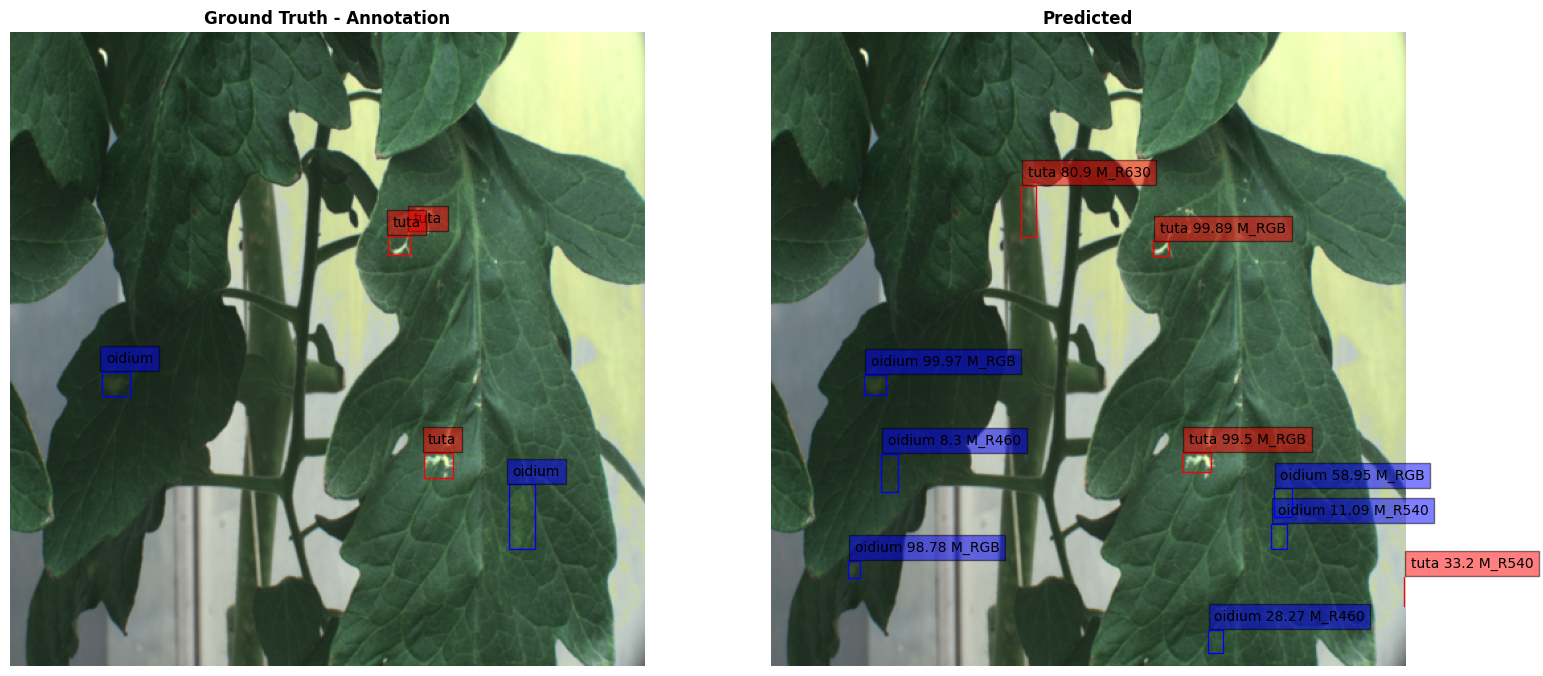

In [347]:
a = 14 # 8 19 28
img_rgb = rgb_data[a] #r540_data[a]
w,h,chanels = img_rgb.shape
label = data_labels[a]
box1 = label[0]['boxes'].numpy()
label1 = label[0]['labels'].numpy()
#print('Image name: ', label[0]['img_name'])
img_r460 = r460_data[a]
img_r540 = r540_data[a]
img_r630 = r630_data[a]
img_r850 = r850_data[a]
img_r980 = r980_data[a]

indexes, boxes, scores, labels, model_names = evaluate_multi_models(img_rgb, img_r460, img_r540, img_r630, img_r850, img_r980)
model_names = list(np.concatenate(model_names).flat)
#print(scores, labels, 'len: ', len(labels), ' len models: ', len(model_names))
print('indexes: ', indexes, 'len: ', len(indexes))

fig, axes = plt.subplots(1, 2, figsize=(18, 10)) 
for i in range(len(label1)):
    x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
    label = str(classes[label1[i]])
    if label == 'tuta':
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'red', facecolor = 'none')
        axes[0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='red', alpha=0.5))
    else:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'blue', facecolor = 'none')
        axes[0].text(x1 + 3, y1 -7, label, bbox=dict(facecolor='blue', alpha=0.5))
    axes[0].add_patch(rect)  
axes[0].imshow(img_rgb)
axes[0].set_title('Ground Truth - Annotation', fontweight ="bold")
axes[0].axis('off')


for idx in indexes:
    if scores[idx] >= 0.07:
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = classes[labels[idx].item()]
        score = scores[idx]
        model_name = model_names[idx]
        if model_name == 'M_RGB' and score < 0.4:
            pass
        elif model_name == 'M_R850' or model_name == 'M_R980' and score < 0.8:
            pass
        else:
            print('Labele', labels[idx].item(), 'Name: ', name, 'Score: ', score, 'Model: ', model_name)
            if name == 'tuta':
                color = 'red'
            else:
                color = 'blue'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = color, facecolor = 'none')
            axes[1].text(x1+5, y1-7, name+' '+str(round(score*100,2))+' '+model_name, bbox=dict(facecolor=color, alpha=0.5))
            axes[1].add_patch(rect)
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'green', facecolor = 'none')
            #axes[0].text(x1+5, y1-7, name+' '+str(round(score*100,2))+' '+model_name, bbox=dict(facecolor=color, alpha=0.5))
            #axes[0].add_patch(rect)
  
axes[1].imshow(img_rgb)
axes[1].set_title('Predicted', fontweight ="bold")
axes[1].axis('off')
plt.show()
